# Incorporating Spatial Autocorrelation into Spatial Predictions

Similarly to example 1, we are using the meuse dataset again to perform a multi-target prediction of soil properties using a regression model. However, in this case we will attempt to account for spatial autocorrelation in the model directly by generating new features that are based on the distance-weighted means of surrounding spatial locations.

In [11]:
import os
import geopandas as gpd
import numpy as np
from copy import deepcopy
from tempfile import NamedTemporaryFile
from pyspatialml import Raster
import pyspatialml.datasets.meuse as ms
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format ='retina'

## Preparing the Raster Predictors

Import the raster predictors from the `pyspatialml.datasets.meuse` module:

In [15]:
predictor_files = ms.predictors
training_pts_file = ms.meuse
stack = Raster(predictor_files)
stack.drop('ffreq')

In order to generate new features from surrounding spatial locations, we need their x,y coordinates, which will will add to the stack of the raster predictors using the `pyspatialml.preprocessing.xy_coordinates` function:

In [18]:
from pyspatialml.preprocessing import xy_coordinates

xy_layers = xy_coordinates(stack.iloc[0], NamedTemporaryFile(suffix=".tif").name)
xy_layers.rename({
    old: new for (old, new) in zip(xy_layers.names, ["x_coord", "y_coord"])},
    in_place=True
)
stack = stack.append(xy_layers, in_place=False)

Quickly plot the raster predictors:

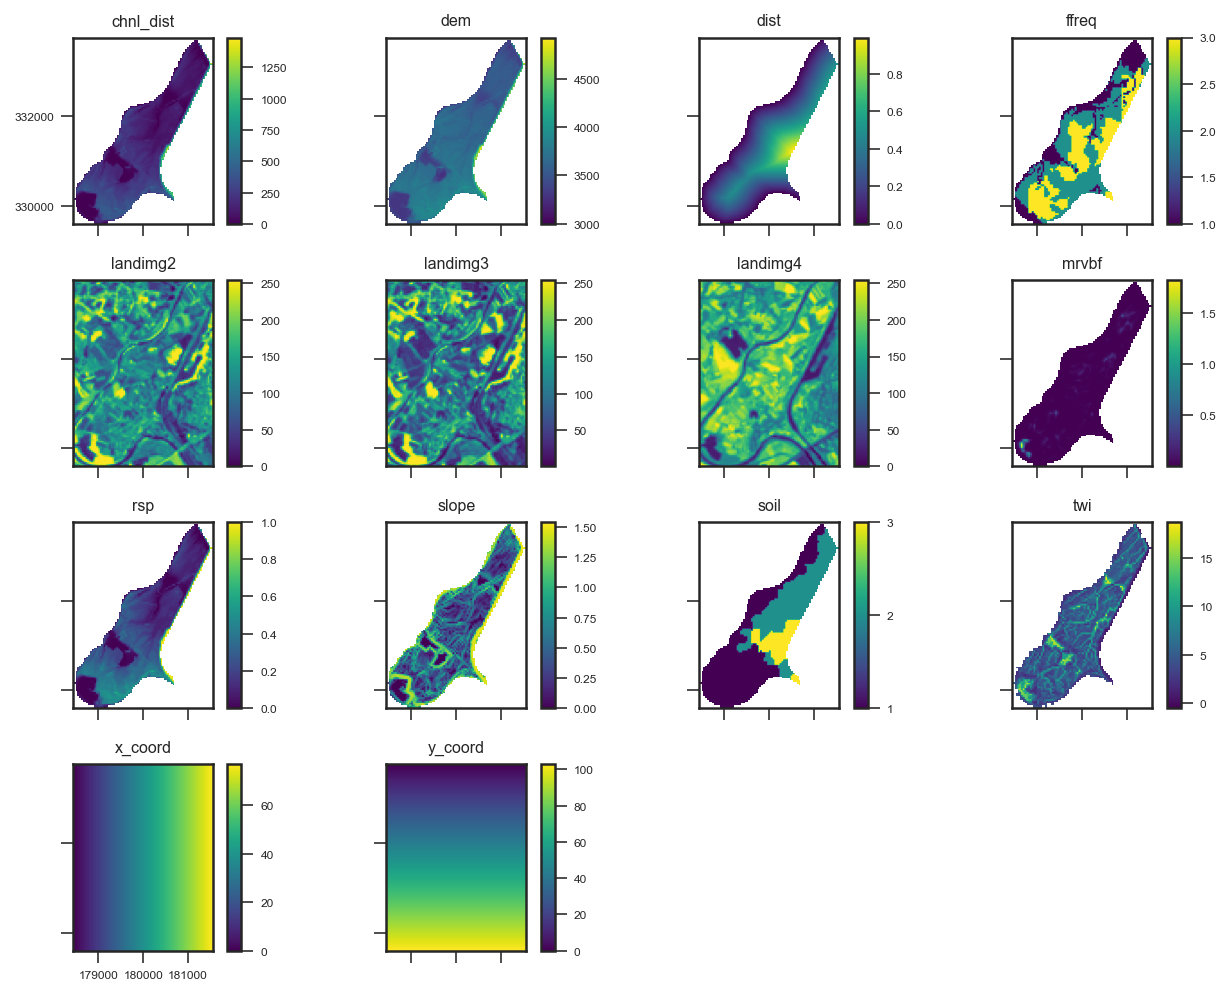

In [19]:
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

## Extract the Training Data

Spatially query the raster predictors at the training point locations:

In [20]:
training_pts = gpd.read_file(training_pts_file)
training_df = stack.extract_vector(gdf=training_pts)

training_df.index = training_df.index.get_level_values("geometry_idx")
training_df = training_df.merge(
    training_pts.loc[:, ("lead", "cadmium", "copper", "zinc", "om")], 
    left_index=True, 
    right_index=True
) 
training_df = training_df.dropna()

Split the response/target variables from the predictors:

In [21]:
X = training_df.loc[:, stack.names].values
y = training_df.loc[:, ['lead', 'cadmium', 'copper', 'zinc', 'om']].values

## Develop a Spatially-Lagged Machine Learning Model

As well as using the ExtraTreeRegressor model which was also used in example 1, here we will use the custom `pyspatialml.estimators.SpatialLagRegressor` metalearner class to wrap the extratrees regressor into a model that adds a new feature based on the distance-weighted mean of spatially-proximal observations:

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from pyspatialml.transformers import KNNTransformer
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import GridSearchCV

# define regressor
et = ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=1234)

soil_index = stack.names.index("soil")
xy_indexes = [stack.names.index(i) for i in ["x_coord", "y_coord"]]

preproc = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), [soil_index]),
    ('lags', KNNTransformer(weights='distance', measure="mean"), xy_indexes)
], remainder='passthrough')

wflow = Pipeline([
    ('preproc', preproc),
    ('regressor', et)
])

search_grid = {"preproc__lags__n_neighbors": [3, 5, 7, 9]}
inner = KFold(n_splits=3, shuffle=True, random_state=1234)
model = GridSearchCV(wflow, param_grid=search_grid, cv=inner, scoring="r2")

Fit the model and cross-validate:

In [32]:
model = model.fit(X, y)
model.best_params_

{'preproc__lags__n_neighbors': 7}

In [33]:
outer = KFold(n_splits=10, shuffle=True, random_state=1234)

scores = cross_validate(model, X, y, scoring='neg_mean_squared_error', cv=outer, n_jobs=1)
rmse = np.sqrt(-scores['test_score']).mean()

print("Our RMSE score is {}".format(rmse))

Our RMSE score is 103.20251099343643


Comparing the RMSE score the the score obtained in example 1, where the spatial structure of the training data was accounted for indirectly by added a variety of raster distance measures, we can see that the RMSE score is slightly improved.

## Multi-Target Predictions

In [34]:
preds = stack.predict(model)
preds.rename(
    {old: new for old, new in zip(preds.names, ['lead', 'cadmium', 'copper', 'zinc', 'om'])},
    in_place=True
)
preds.lead.cmap = 'rainbow'
preds.cadmium.cmap = 'rainbow'
preds.copper.cmap = 'rainbow'
preds.zinc.cmap = 'rainbow'
preds.om.cmap = 'rainbow'

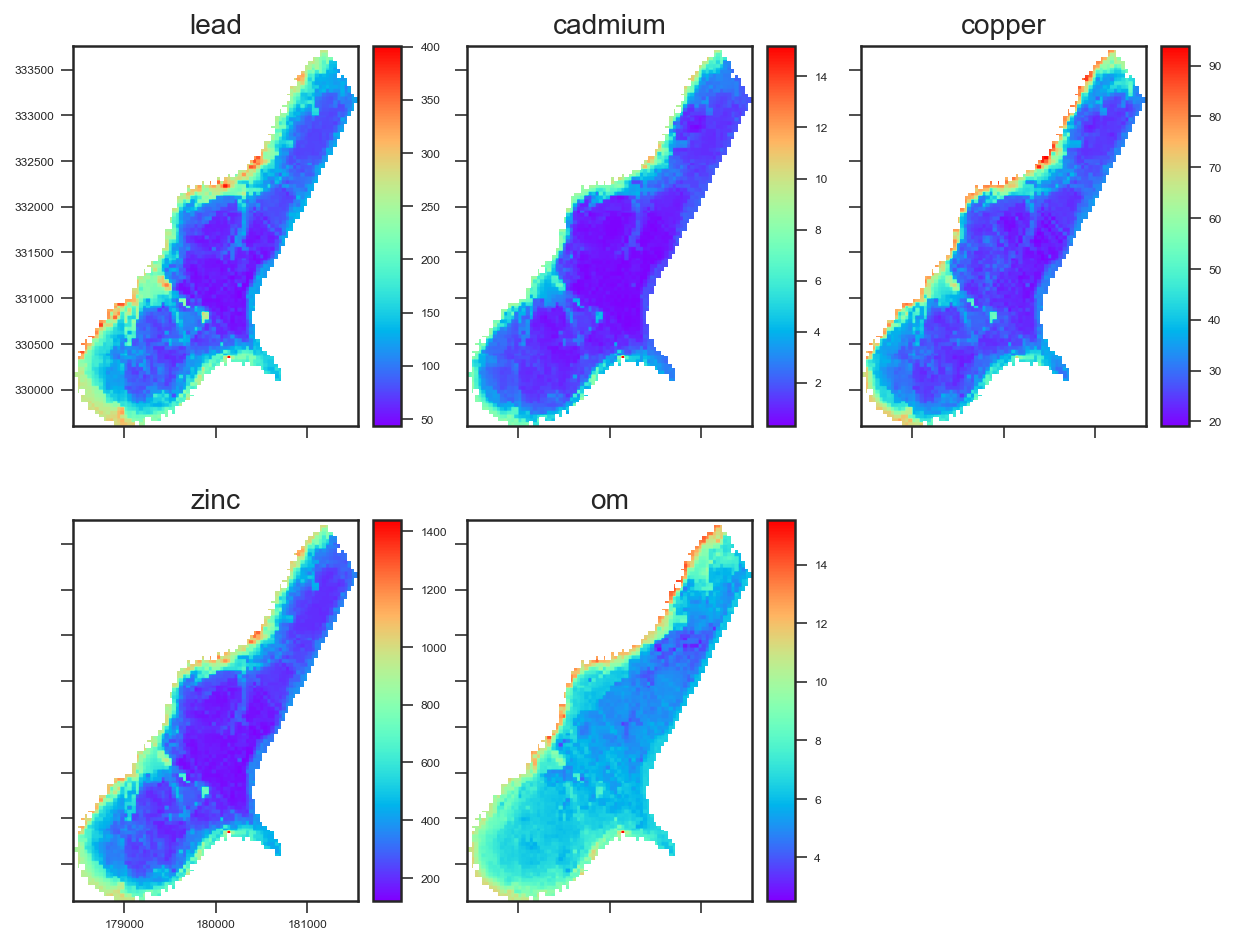

In [35]:
mpl.style.use('seaborn-ticks')
preds.plot(out_shape=(200, 200), title_fontsize=14, figsize=(10, 8))
plt.show()